In [1]:
#-*- coding:utf-8 -*-
import os
import sys
import requests
import csv
import json

#키와 url 정의
key = "ttbsujoo851359001"
url = f"http://www.aladin.co.kr/ttb/api/ItemList.aspx?ttbkey=ttbsujoo851359001&QueryType=Bestseller&MaxResults=100" \
      "&start=1&SearchTarget=Book&output=js&Version=20131101&CategoryId=1"
  
#request 보내기
response = requests.get(url)
response_json = json.loads(response.text)  

#받은 response를 csv타입으로 바뀌주기
f = open('bookdata.csv','w',newline='')
writer=csv.writer(f)

writer.writerow(['ISBN13','TITLE','AUTHOR','PUBLISHER','PRICE','CATEGORY','RANK'])
for item in response_json['item']:
    writer.writerow([item['isbn13'],item['title'],item['author'],item['publisher'],
               item['priceStandard'],item['categoryName'],item['customerReviewRank']])
f.close()

In [2]:
import pandas as pd
df = pd.read_csv('bookdata.csv')
print(df.columns)

Index(['ISBN13', 'TITLE', 'AUTHOR', 'PUBLISHER', 'PRICE', 'CATEGORY', 'RANK'], dtype='object')


In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

filename='bookdata.csv'
df = pd.read_csv(filename)
isbn13_list = df['ISBN13']

# 결과값 저장, 2차원 리스트
values = list()

for idx1, isbn13 in enumerate(isbn13_list):
    try:
        isbn13 = int(isbn13)
        print(isbn13)

        url1 = f'https://www.aladin.co.kr/shop/wproduct.aspx?ISBN={isbn13}'

        res = requests.get(url1)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "lxml")
        
        #item id 찾기
        item_id_url = soup.find('div', attrs={'class': 'tlist'}).ul.li.div.a['href']
        item_id = item_id_url[item_id_url.find('=') + 1:]


        url2 = f'https://www.aladin.co.kr/ucl/shop/product/ajax/GetCommunityListAjax.aspx?itemId={item_id}&IsAjax=true&pageType=1&sort=1&communitytype=CommentReview&IsOrderer=2&pageCount=500'

        res = requests.get(url2)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "lxml")

        np_40box_list_cont_list = soup.find_all("div", attrs={"class":"np_40box_list_cont"})

        for idx2, np_40box_list_cont in enumerate(np_40box_list_cont_list):

            for idx3, np_40box_list_cont_element in enumerate(np_40box_list_cont):
                if idx3 == 1:
                    src = np_40box_list_cont_element.img["src"]
                    rating = src[-5] if src[-5] != '0' else '10'
                elif idx3 == 3:
                    review = np_40box_list_cont_element.get_text().strip()
                    break
            values.append([isbn13, review])
            #print(review)

    except  Exception as e:
        print('#' * 20)
        print(url1)
        print(e)
        print('#' * 20)
        
# csv 파일 쓰기
filename = filename.split('\\')
df = pd.DataFrame(values, columns=['ISBN13', 'review'])
df.to_csv(f'csv_reviews.csv',  encoding='utf-8-sig',index=False)

9791167370280
9791191056556
9791165341909
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9791165341909
'NoneType' object has no attribute 'ul'
####################
9791167140050
9788954679947
9788954678407
9788926718803
9791191193138
9791130637617
9788932921037
9788937472060
9788932921044
9791197063275
9791166119651
9788932038674
9788956609959
9788937461033
9788954679930
9788970129815
9791190582438
9788956604992
9791136735638
9788936434267
9791196484194
9788970129822
9788925588735
9791159923340
9788936438456
9788936434496
9788937417566
9791190090018
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9791190090018
'NoneType' object has no attribute 'ul'
####################
9788972756194
####################
https://www.aladin.co.kr/shop/wproduct.aspx?ISBN=9788972756194
'NoneType' object has no attribute 'ul'
####################
9791196866792
9791191253313
9788936424589
9788936438418
9791134830557
9791185152431
9788954672214
9788983928207
97911

In [4]:
!pip install python-Levenshtein
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [16]:
print(df)

             ISBN13                                             review
0     9791167370280  첫 장면부터 영상미가 엄청납니다. 묘사가 집요하면 늘어지는 느낌이 들 수도 있는데 ...
1     9791167370280  이 정도면 고유정한테 로열티 줘야지.그냥 고유정 얘기지 이게 무슨...작가의 말 민...
2     9791167370280                       10쪽 오타있네요.6째줄민서기가아니고 믹서기 입니다
3     9791167370280  은호, 재인, 지유 등 모든 등장인물에 몰입되어 그들의 입장을 들여다보고 공감하게된...
4     9791167370280  어떻게 이렇게 자세하게 상세하게 글로 표현하는게 가능한건지 책을 읽고 있는게 아니라...
...             ...                                                ...
2120  9791190885713           끝을 미리 알더라도 사랑하는 사람의 손을 잡고 직진하는 미아가 좋았어요!
2121  9791190885713  내용이나 주제도 좋았지만 곰곰이 생각하게 만드는 문장이 많아서 꼭 여러번 읽어보고 ...
2122  9791190885713                                    싸인본 왔으면 좋겠어요...
2123  9791136278593                                 와... 아야세니까 거를 수 없어
2124  9791136278593                                       어? 나온다고? 이게?

[2125 rows x 2 columns]


In [17]:
train_data= df
print(train_data[:20])
train_data.columns

           ISBN13                                             review
0   9791167370280  첫 장면부터 영상미가 엄청납니다. 묘사가 집요하면 늘어지는 느낌이 들 수도 있는데 ...
1   9791167370280  이 정도면 고유정한테 로열티 줘야지.그냥 고유정 얘기지 이게 무슨...작가의 말 민...
2   9791167370280                       10쪽 오타있네요.6째줄민서기가아니고 믹서기 입니다
3   9791167370280  은호, 재인, 지유 등 모든 등장인물에 몰입되어 그들의 입장을 들여다보고 공감하게된...
4   9791167370280  어떻게 이렇게 자세하게 상세하게 글로 표현하는게 가능한건지 책을 읽고 있는게 아니라...
5   9791167370280  멈추지 못하고 한 번에 읽었습니다. 흡인력이 엄창나요. 전작인 종의 기원에서 느껐던...
6   9791167370280  소설 자체는 잘 썼습니다. 너무 잘 써서 소설 속에 고유정이 살아숨쉬는 것 같아 읽...
7   9791167370280  26쪽까지 읽다 덮음...굳이 고유정사건을 바탕으로 해야했나...딱봐도 고유정사건같...
8   9791167370280  밤새 읽는데 무서워서 죽는줄 알았다.  내용이나 전개는 다 예상대로였는데 그래도 무...
9   9791167370280  읽는내내 긴장감은 커졌고 기대감은 작아졌다. 읽는 것인지 보는 것인지 헷갈리게 술술...
10  9791167370280                            읽다보니 고유정 사건이 모티브...좀 실망
11  9791167370280  너무 기대하고 고대하다가 첫페이지 넘기는 순간...고*정 사건을 모티브로 하신 것 ...
12  9791167370280                        생각보다 두꺼웠지만 단숨에 완독 했네요~재밌어요~
13  9791167370280  어떻게 될 지 무슨 일이 벌

Index(['ISBN13', 'review'], dtype='object')

In [23]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['review'] = train_data['review'].str.replace("[^가-힣1-9 ]","") #정규화
print(train_data)

             ISBN13                                             review
0     9791167370280  첫 장면부터 영상미가 엄청납니다 묘사가 집요하면 늘어지는 느낌이 들 수도 있는데 숙...
1     9791167370280   이 정도면 고유정한테 로열티 줘야지그냥 고유정 얘기지 이게 무슨작가의 말 민망하지 않나
2     9791167370280                         1쪽 오타있네요6째줄민서기가아니고 믹서기 입니다
3     9791167370280  은호 재인 지유 등 모든 등장인물에 몰입되어 그들의 입장을 들여다보고 공감하게된다 ...
4     9791167370280  어떻게 이렇게 자세하게 상세하게 글로 표현하는게 가능한건지 책을 읽고 있는게 아니라...
...             ...                                                ...
2120  9791190885713            끝을 미리 알더라도 사랑하는 사람의 손을 잡고 직진하는 미아가 좋았어요
2121  9791190885713  내용이나 주제도 좋았지만 곰곰이 생각하게 만드는 문장이 많아서 꼭 여러번 읽어보고 ...
2122  9791190885713                                       싸인본 왔으면 좋겠어요
2123  9791136278593                                    와 아야세니까 거를 수 없어
2124  9791136278593                                          어 나온다고 이게

[2125 rows x 2 columns]


<ipython-input-23-3c49906f1d21>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^가-힣1-9 ]","") #정규화


In [24]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [25]:
# 불용어 정의
file=open('bool.txt','r',encoding='UTF8')
stopwords=file.readlines()[0].split(' ')
file.close()

In [33]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [39]:
from gensim.models import Word2Vec
model = Word2Vec(
    sentences = tokenized_data, 
    vector_size = 100, # 문자 벡터 차원 수
    window = 5, # 문자열 창 크기 : 중심 단어를 예측하기 위해서 앞, 뒤로 몇 개의 단어를 볼지 결정
    min_count = 10, # 최소 문자 수
    workers = 4, # 병렬 처리 스레드 수
    sg = 1 #0은 CBOW, 1은 Skip-gram
    #CBOW는 주변에 있는 단어로 중간에 있는 단어를 예측
    #Skip-gram은 중심 단어에서 주변 단어를 예측
)

In [42]:
print(model.wv.index_to_key)

['읽다', '책', '작가', '소설', '좋다', '너무', '이야기', '기대', '다', '작품', '인간', '싶다', '재밌다', '정말', '유정', '글', '정', '들다', '력', '자다', '못', '되어다', '재미있다', '나오다', '내용', '문장', '영화', '대한', '그렇다', '어떻다', '느끼다', '많다', '가다', '마음', '밤', '모르다', '느낌', '묘사', '권', '기다리다', '궁금하다', '고', '요', '7년', '만들다', '삶', '주인공', '보고', '받다', '감정', '구매', '이렇다', '오다', '표현', '듯', '재미', '정유', '몰입', '해주다', '시선', '읽히다', '추천', '아쉽다', '끝', '기대하다', '새롭다', '처음', '시작', '악', '역시', '이라', '사랑', '주다', '한국', '최고', '전개', '좋아하다', '인물', '꼭', '버리다', '무섭다', '많이', '종', '쓰다', '엔', '한번', '에도', '기원', '느껴지다', '놓다', '흡입', '내내', '마지막', '서사', '기분', '독자', '처럼', '1', '스토리', '진짜', '손', '이라는', '쓸다', '계속', '공감', '여성', '사건', '부분', '거', '믿다', '내다', '이나', '크다', '감', '문학', '넘다', '이해', '없이', '인데', '세상', '가장', '긴장감', '빠지다', '해보다', '신작', '인지', '오랜', '소재', '깊다', '쉬다', '덮다', '그냥', '모든', '나다', '장', '제목', '이란', '결말', '돼다', '이제', '먹다', '힘', '페이지', '차다', '사다', '한편', '모습', '매력', '인가', '키르케', '보여주다', '구성', '심리', '전작', '만에', '28', '걸', '빨리', '따뜻하다', '젊다', '건', '만나다', '별', '첫', 

In [51]:
print(model.wv.most_similar("7년"))

[('밤', 0.9889427423477173), ('28', 0.9887772798538208), ('읽다', 0.9820101261138916), ('재밌다', 0.9798436760902405), ('역시', 0.9796890020370483), ('팬', 0.9793553948402405), ('신작', 0.9787602424621582), ('정작', 0.9782450795173645), ('가의', 0.9780977368354797), ('재미있다', 0.9780541658401489)]


C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


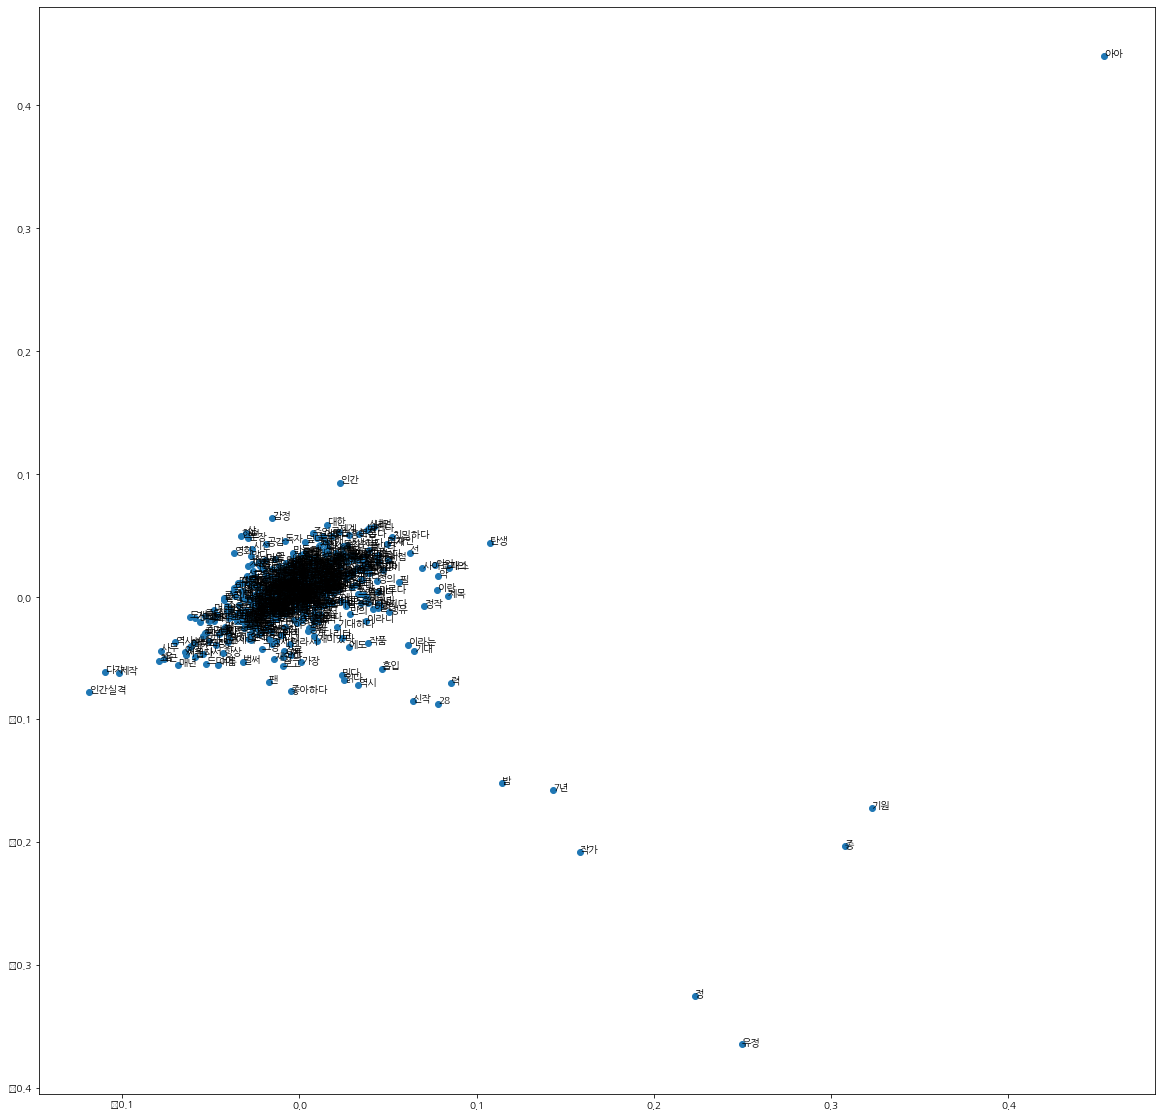

In [43]:
word_vectors = model.wv
vocabs =  list(model.wv.index_to_key)
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

rc('font',family="NanumGothic")

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

In [38]:
#Matplotlib의 한글 폰트 정보 조회
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 


386
